# Data-driven modeling of a Tank/Manifold System

This tutorial performs the data-driven modeling of a pair of tanks connected by a common manifold.

**Problem Setup:**

Consider two water tanks of different area-height profiles connected at their base by a common pipe/manifold network that is fed by a pump:

![Tank-manifold diagram](figs/manifold.png)

Here, a volumetric flow out of the pump enters a manifold where the flow splits into two streams; one into each tank. The split of flow between these two streams is equal to the input. In mathematical terms:
$$
q_\text{pump} = q_2 + q_2.
$$
Similarly, we can write down evolution equations for the heights of the tanks:
$$
\frac{dh_1}{dt} = \frac{1}{A_1 \left( h_1 \right)}q_1
$$
$$
\frac{dh_2}{dt} = \frac{1}{A_2 \left( h_2 \right)}q_2 . 
$$

Now, suppose we have two goals: from measurements of tank heights and flows and knowledge of $A_1(h)$, (i) predict the evolution of the system, and (ii) learn the other area-height tank profile. Let's start by training a Neural ODE to learn the dynamics of the system. 

**Modeling in Neuromancer:**

Let's do this task in Neuromancer. Here are the relevant imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os

import neuromancer.slim as slim
from neuromancer.modules import blocks, activations
from neuromancer.dynamics import integrators, ode, physics
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.constraint import variable, Objective
from neuromancer.system import Node, System
from neuromancer.loggers import BasicLogger

from collections import OrderedDict
from abc import ABC, abstractmethod

torch.manual_seed(0)
device = 'cpu'

We also want to keep our plots clean and uniform - let's set the defaults now:

In [2]:
plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Times"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 10})

params = {'legend.fontsize': 10,
         'axes.labelsize': 10,
         'axes.titlesize': 10,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

**Data Loading and preparation**

For this problem, we load data from a text file and construct the dataset.

In [3]:
data = np.float32(np.loadtxt('data/tanks.dat'))
data=data[1:497,]
area_data = np.loadtxt('data/area.dat')
time = np.float32(np.linspace(0.0,len(data[:,0])-1,len(data[:,0])).reshape(-1, 1))
U = time*0.0 + 0.5

train_data = {'Y': data[1:], 'X': data[1:], 'Time': time[1:], 'U': U[1:] }
dev_data = train_data
test_data = train_data

nsim = data.shape[0]
nx = data.shape[1]
nstep = 15

for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(nsim//nstep, nstep, nx)
    d['Y'] = d['Y'].reshape(nsim//nstep, nstep, nx)
    d['xn'] = d['X'][:, 0:1, :] # Add an initial condition to start the system loop
    d['Time'] = d['Time'].reshape(nsim//nstep, nstep, 1)
    d['U'] = d['U'].reshape(nsim//nstep, nstep, 1)

train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader, test_loader = [DataLoader(d, batch_size=nsim//nstep, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset, dev_dataset]]

nx = 4 # set the state dimension
nu = 1 # set the exogenous input dimension

# State names if we need them (we do)
states = {}
states['h_1'] = 0
states['h_2'] = 1
states['m_1'] = 2
states['m_2'] = 3
states['m'] = 4

**Data Visualization:**

Now that we have our data loaded, we can take a look at the system dynamics:

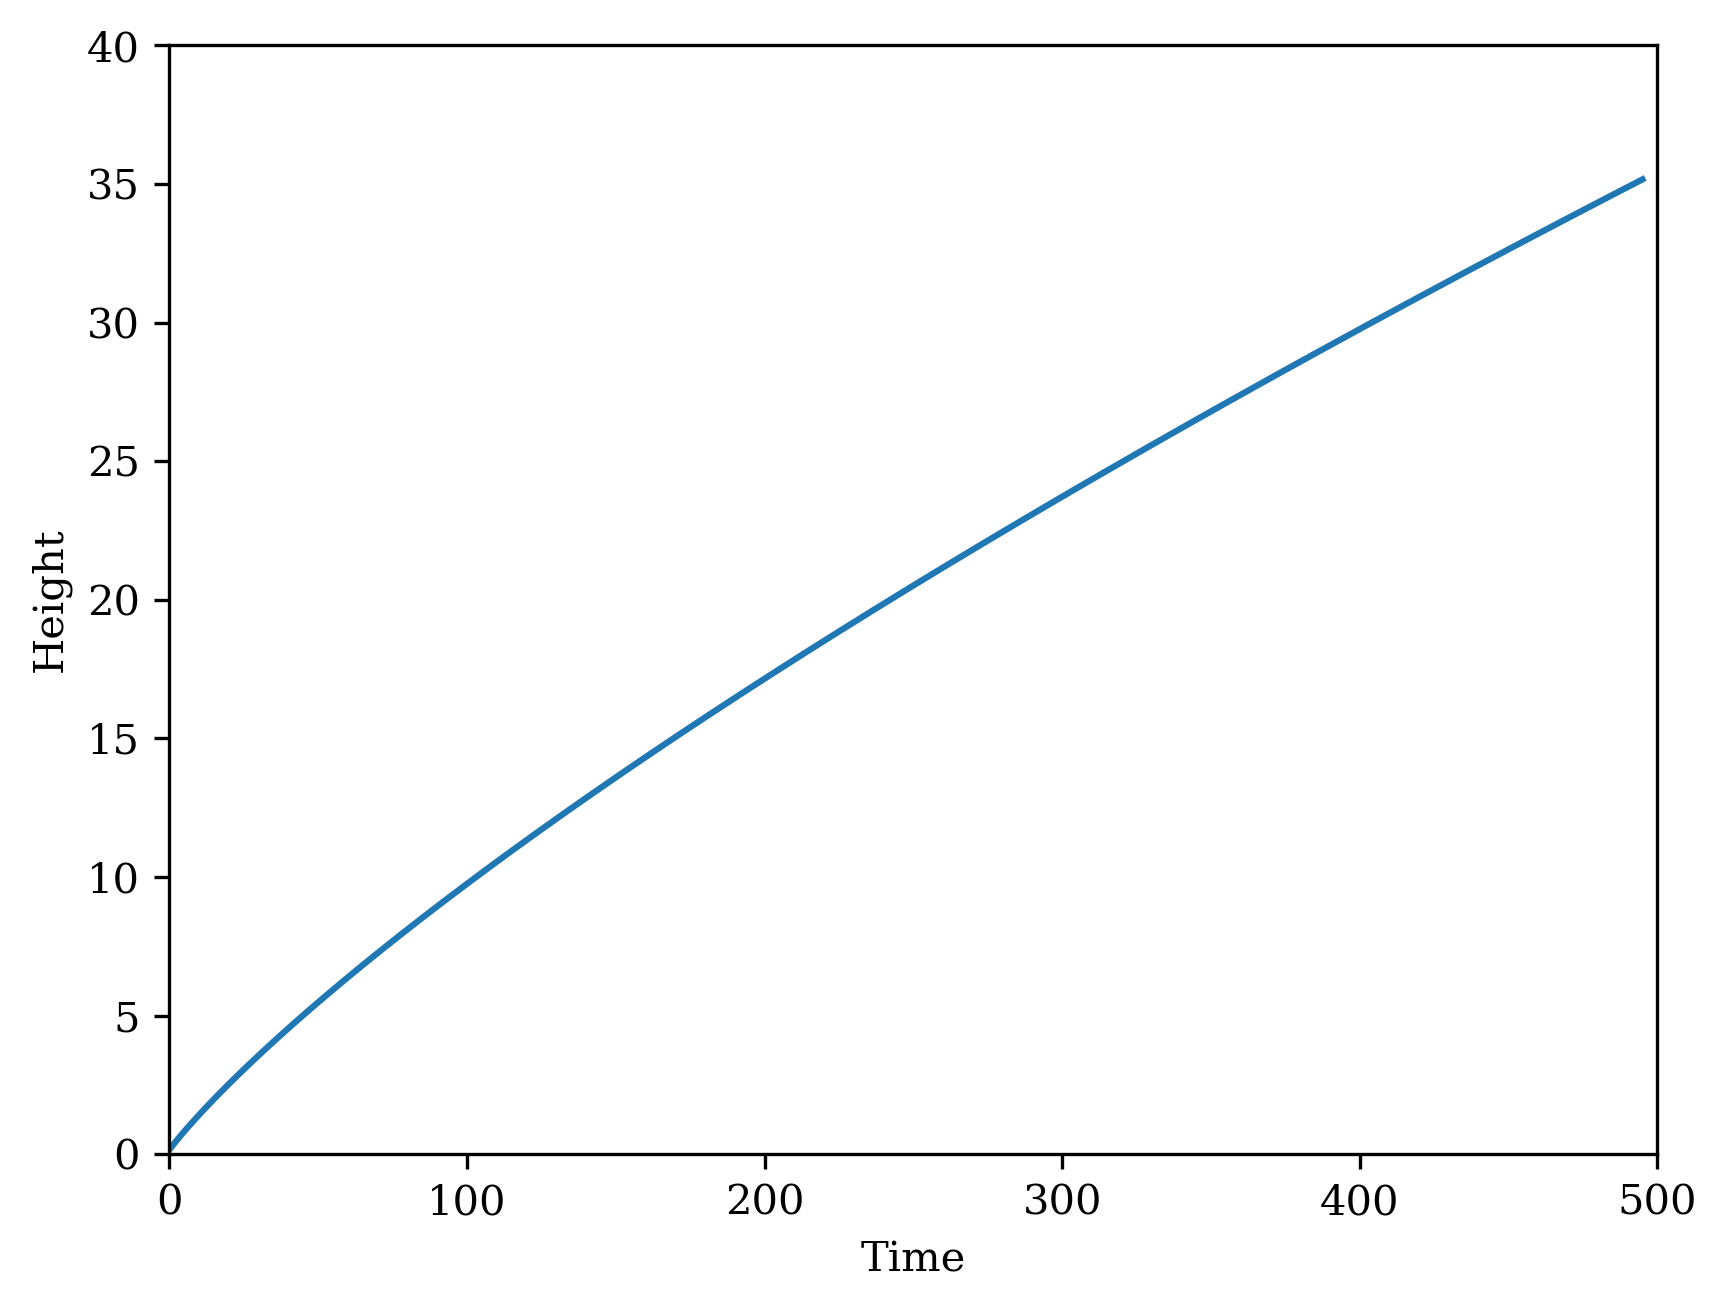

In [4]:
plt.plot(time,data[:,0])
plt.xlim([0,500])
plt.ylim([0,40])
plt.xlabel("Time")
plt.ylabel("Height")
plt.show()


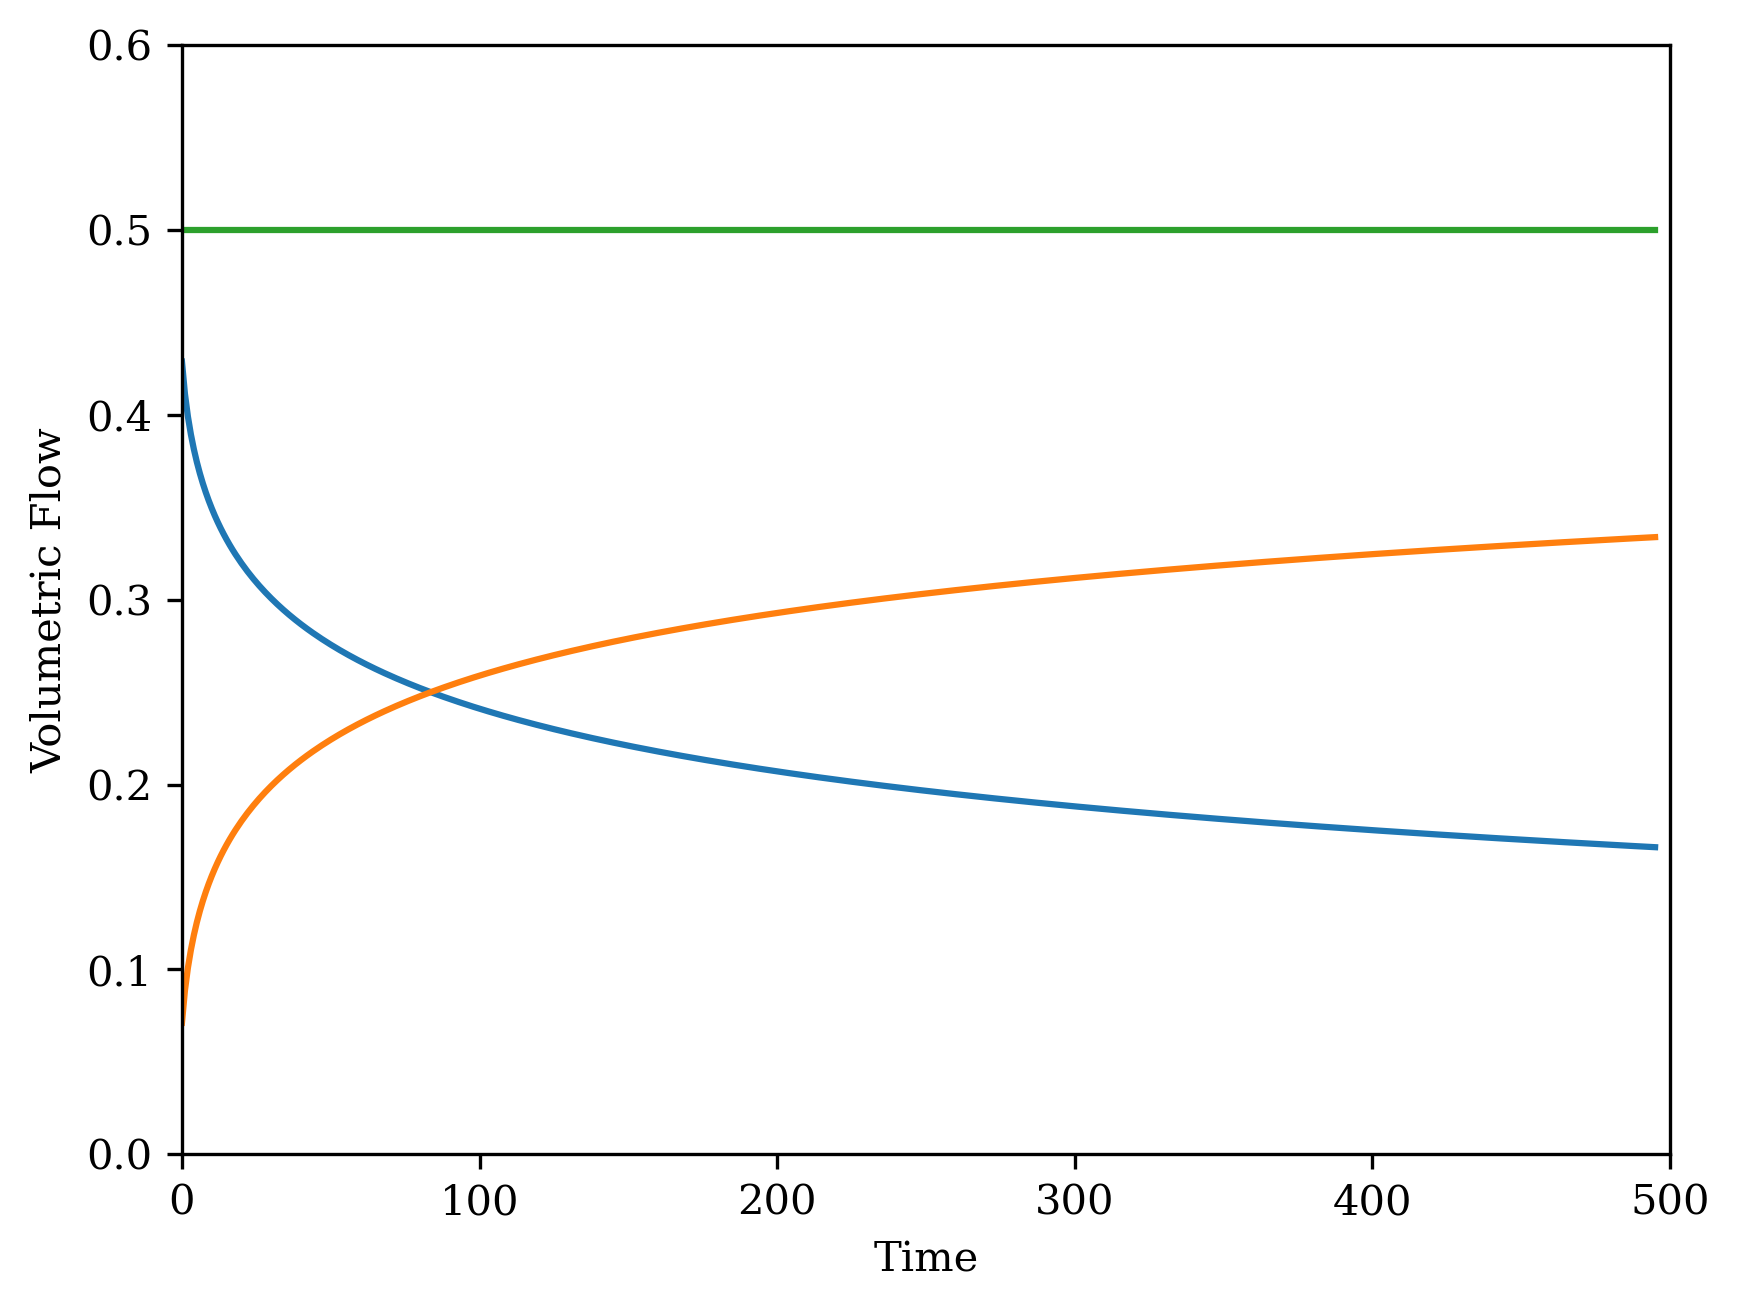

In [5]:
plt.plot(time,data[:,[2,3]])
plt.plot(time,data[:,2]+data[:,3])
plt.xlim([0,500])
plt.ylim([0,0.6])
plt.xlabel("Time")
plt.ylabel("Volumetric Flow")
plt.show()

There are a couple of things to note here. First, the heights of the two tanks are equivalent for all time. This is because although the tanks are of different area-height profiles, and therefore volumes, their evolution is constrained such that each has the same hydrostatic pressure head. Similarly, the volumetric flow into each tank varies as a function of time. Notice how adding the curves together yield the third (constant) curve at 0.5. This is because of the conservation relationship at the manifold: what goes in must come out!

**Model Construction:**

Let's start by defining a non-autonomous ODE to evolve the states over the time period of interest:


In [6]:
# define neural network of the NODE
fx = blocks.MLP(nx+nu, nx, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[10, 10])

fxRK4 = integrators.RK4(fx, h=1.0)

dynamics_model = System([Node(fxRK4,['xn','U'],['xn'])])


Now we need a loss function. Here, we use Neuromancer's built-in Variable abstraction to construct a loss that penalizes the misfit in flow rates and the height discrepancy between the two tanks:

In [7]:
x = variable("X")
xhat = variable("xn")[:, :-1, :]
reference_loss = ((xhat[:,:,[2,3]] == x[:,:,[2,3]])^2)
reference_loss.name = "ref_loss"

height_loss = (1.0e0*(xhat[:,:,0] == xhat[:,:,1])^2)
height_loss.name = "height_loss"

objectives = [reference_loss, height_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)
optimizer = torch.optim.Adam(problem.parameters(), lr=0.01)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=10000,
    patience=20,
    warmup=50,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=None,
)

In [8]:
best_model = trainer.train()


epoch: 0  train_loss: 361.18109130859375
epoch: 1  train_loss: 177.46018981933594
epoch: 2  train_loss: 86.99143981933594
epoch: 3  train_loss: 43.273536682128906
epoch: 4  train_loss: 20.912870407104492
epoch: 5  train_loss: 9.351593017578125
epoch: 6  train_loss: 3.290347099304199
epoch: 7  train_loss: 0.9612399339675903
epoch: 8  train_loss: 6.165356159210205
epoch: 9  train_loss: 10.364153861999512
epoch: 10  train_loss: 8.532082557678223
epoch: 11  train_loss: 5.270593643188477
epoch: 12  train_loss: 4.419445991516113
epoch: 13  train_loss: 3.289616346359253
epoch: 14  train_loss: 2.0178794860839844
epoch: 15  train_loss: 1.1312956809997559
epoch: 16  train_loss: 0.8535256385803223
epoch: 17  train_loss: 0.6974184513092041
epoch: 18  train_loss: 0.5534299612045288
epoch: 19  train_loss: 0.4380740523338318
epoch: 20  train_loss: 0.3549269139766693
epoch: 21  train_loss: 0.29896360635757446
epoch: 22  train_loss: 0.262856662273407
epoch: 23  train_loss: 0.24299371242523193
epoch: 24

To make our lives easier, let's make a quick plotting function to use (we'll use this again later):

In [9]:
def process_and_plot(integrator):

    # Roll out the model:
    end_step = len(data[:,0])
    sol = torch.zeros((end_step,5))
    sol[:,-1] = 0.5
    x0 = np.concatenate((data[0,:],U[0]))
    ic = torch.unsqueeze(torch.tensor(x0),0).float()
    t = 0
    for j in range(sol.shape[0]-1):
        if j==0:
            sol[[0],:] = ic
            sol[[j+1],:4] = integrator(sol[[0],:4],sol[[0],-1:])
        else:
            sol[[j+1],:4] = integrator(sol[[j],:4],sol[[j],-1:])
        t += time[1]-time[0]

    # plot the results
    plt.plot(time,sol.detach().numpy()[:,0],label="Tank #1")
    plt.plot(time,sol.detach().numpy()[:,1],label="Tank #2")
    plt.plot(time,data[:,0],label="Data",linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Height")
    plt.legend()
    plt.show()

    plt.plot(time,sol.detach().numpy()[:,2],label="Inflow #1")
    plt.plot(time,sol.detach().numpy()[:,3],label="Inflow #1")
    plt.plot(time,np.sum(sol.detach().numpy()[:,[2,3]],-1),label="In_1 + In_2")
    plt.plot(time,data[:,2],label="Data Inflow #1",linestyle="--")
    plt.plot(time,data[:,3],label="Data Inflow #2",linestyle="--")

    plt.xlim([0,500])
    plt.ylim([0,0.6])
    plt.xlabel("Time")
    plt.ylabel("Volumetric Flow")
    plt.legend()
    plt.show()

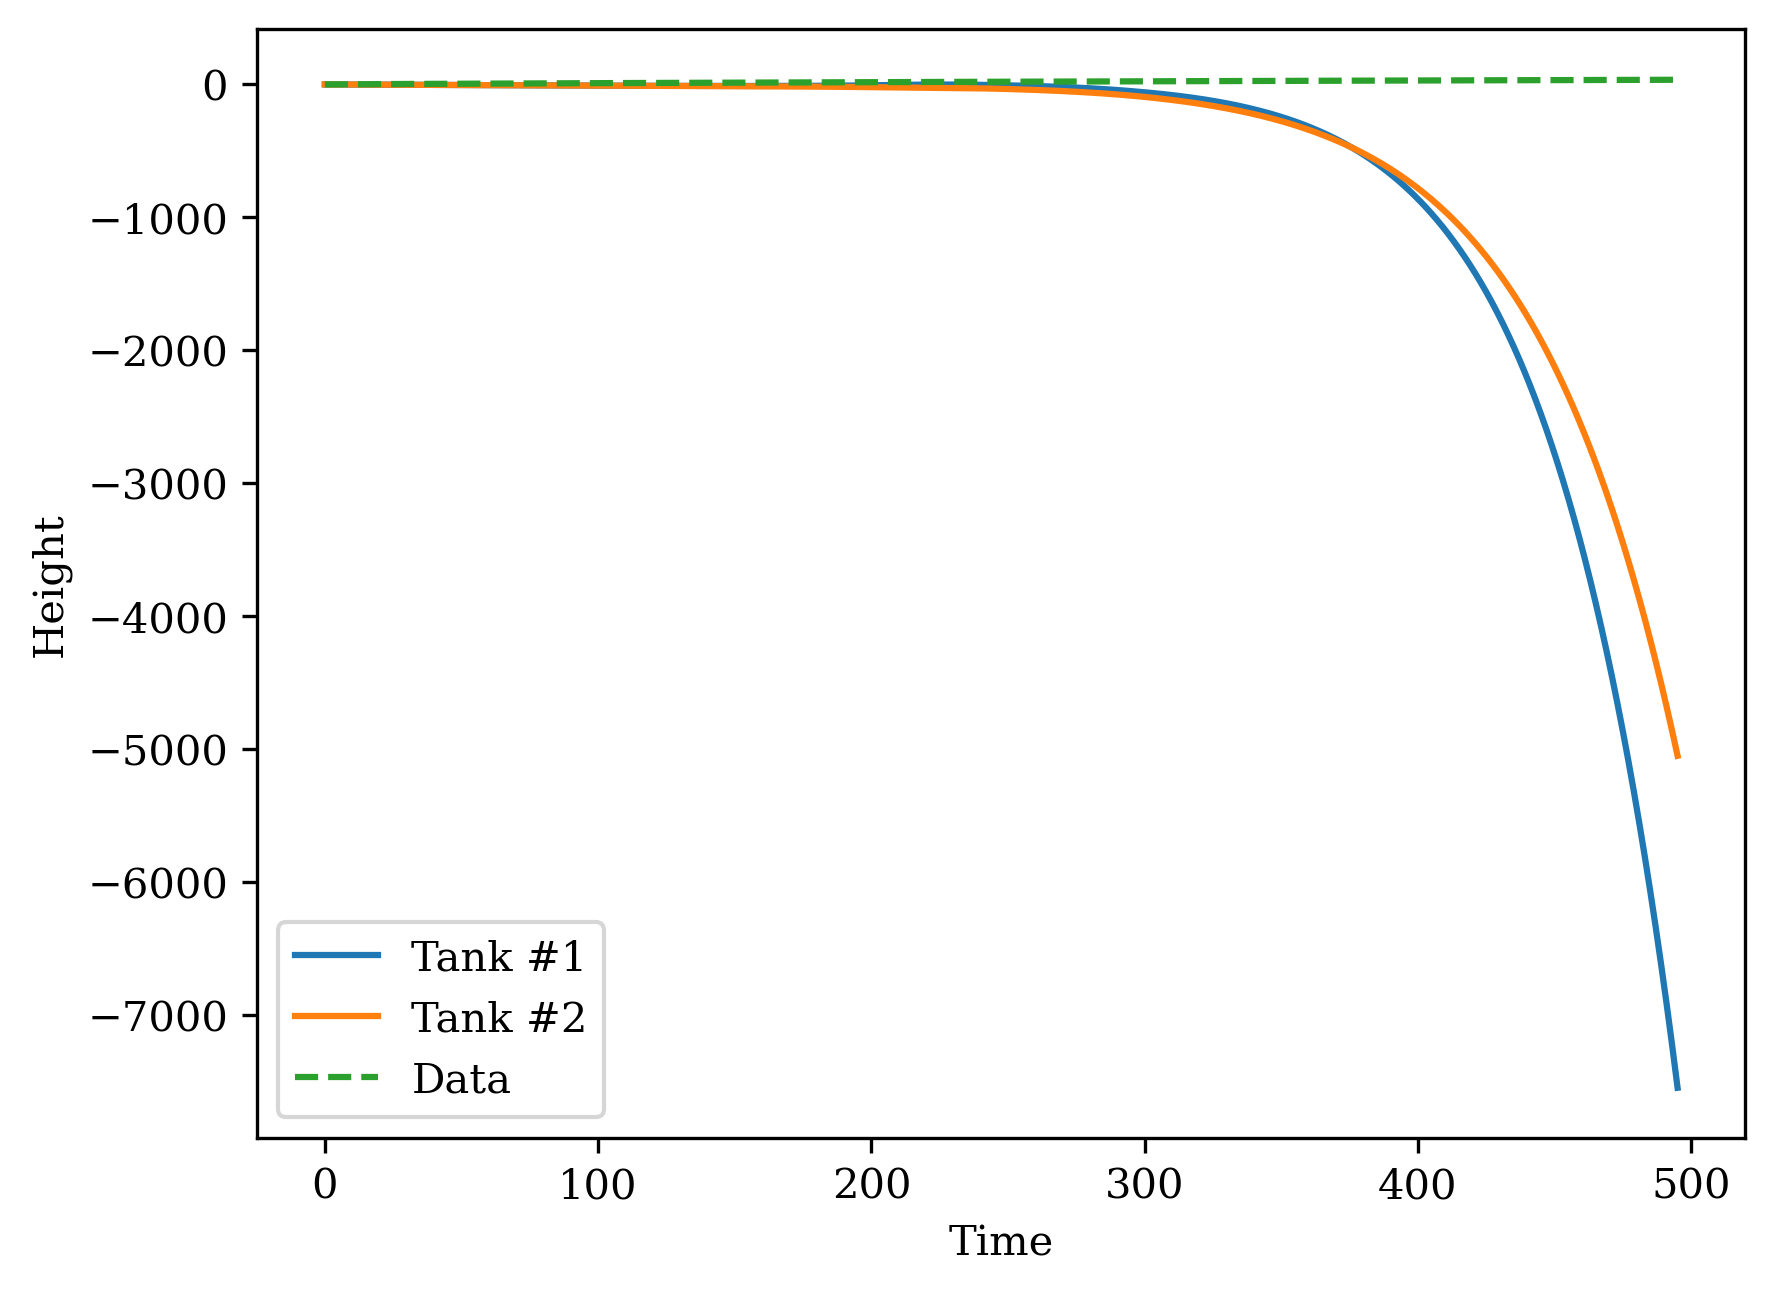

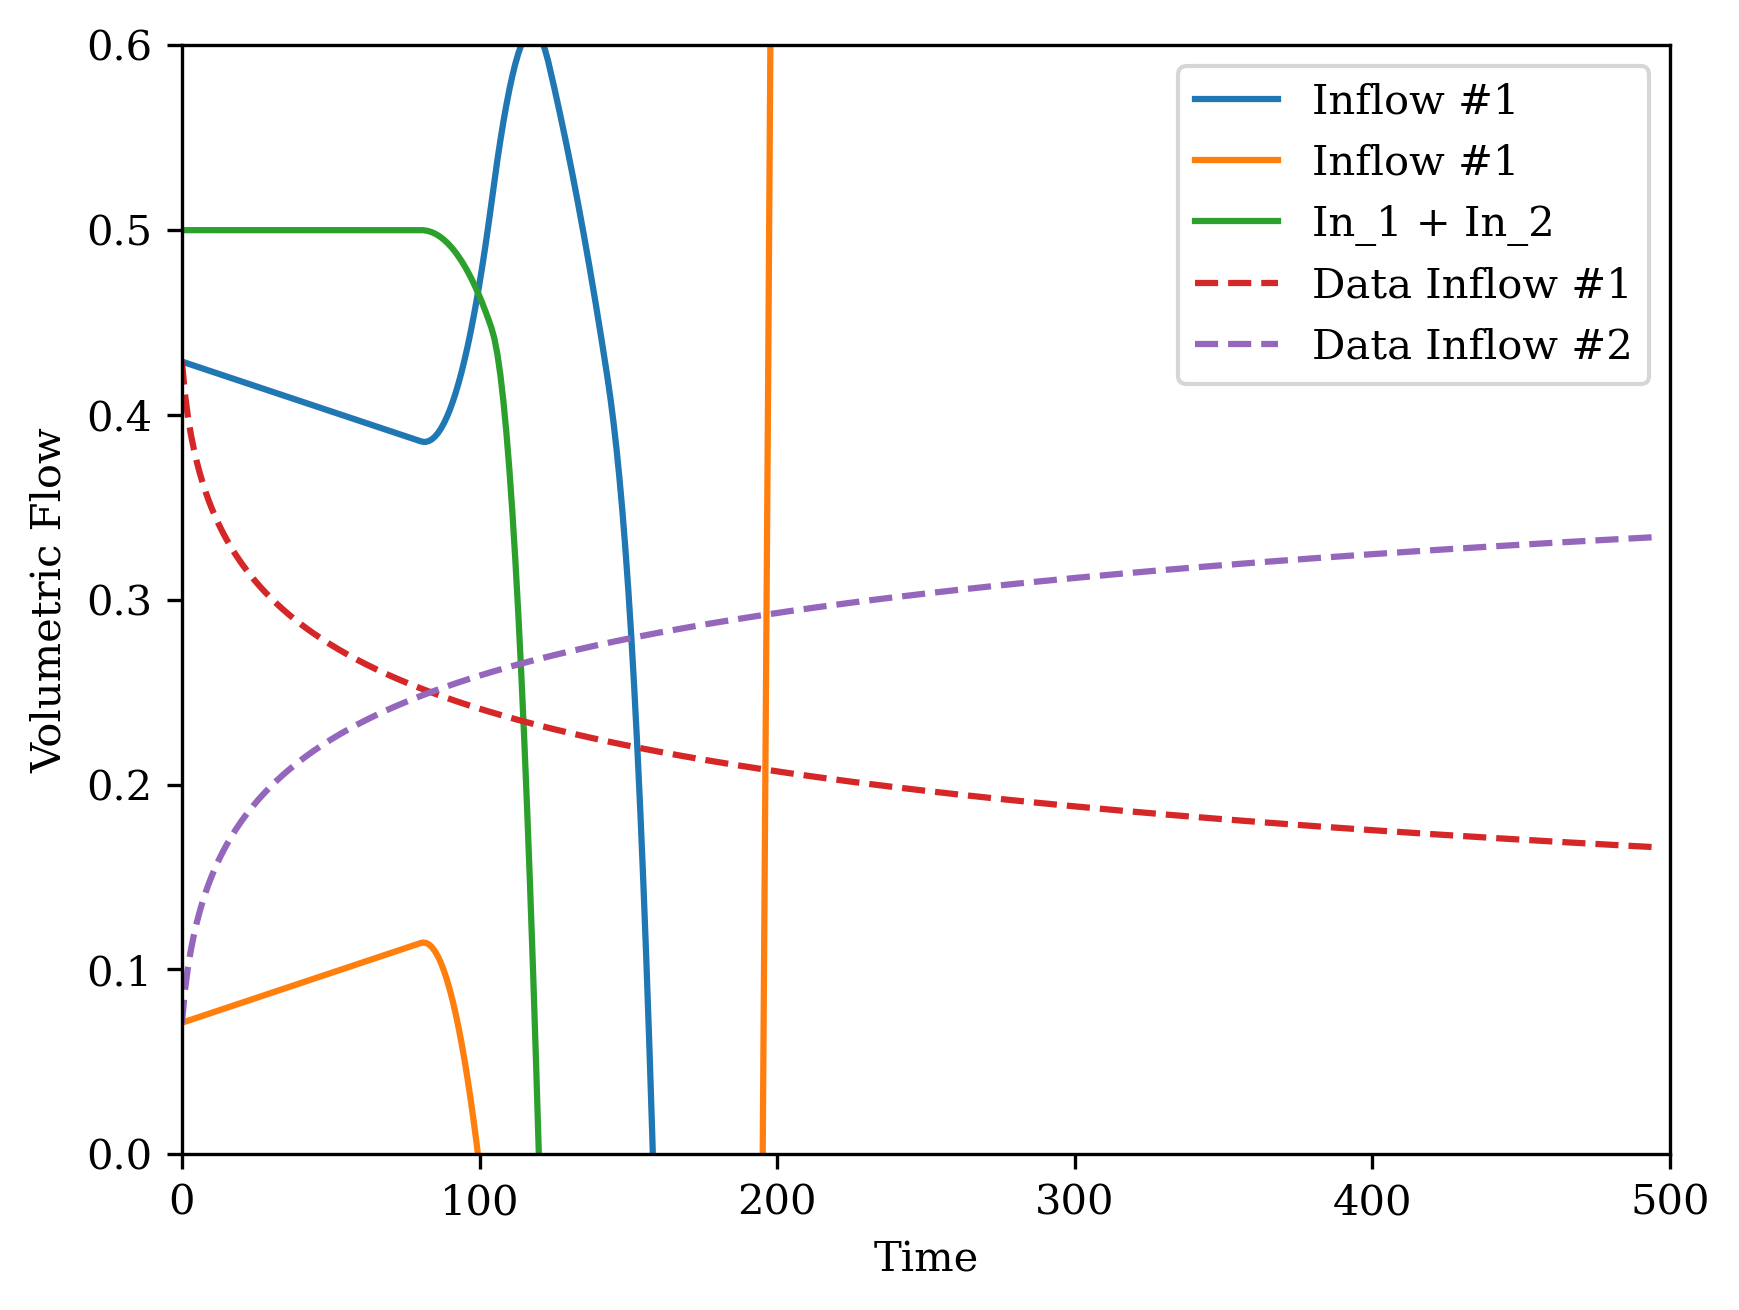

In [10]:
process_and_plot(fxRK4)

Oh no! What happened? How come the results look very bad? In fact, is that a *negative height*? And those flow rates don't add up to the pump flow rate? We need to do something different.

**Neural Differential Algebraic Equations**

The constraints we saw in the problem setup should probably be obeyed - but how? The governing equations for the system are:
$$
\frac{dh_1}{dt} = \frac{1}{A_1 \left( h_1 \right)}q_1
$$
$$
\frac{dh_2}{dt} = \frac{1}{A_2 \left( h_2 \right)}q_2 . 
$$
$$
0 = q_\text{pump} - q_2 - q_2.
$$
$$
0 = h_1 - h_2
$$
The above equations constitute a Differential-Algebraic Equation; that is, a system of equations where some states evolve according to ODEs and others evolve according to algebraic relationships. Here, the heights of the tanks are *differential* variables and the flows $q_i$ are *algebraic* variables. We need an algorithm to handle these appropriately.

In explicit timestepping for ODEs, we obtain a future state by recursive application of a rule. For example, in Forward Euler, we write:
$$
\mathbf{x}\left(t+\Delta t\right) = \mathbf{x}(t) + \Delta t f\left( \mathbf{x}(t)\right) = \text{ODESolve}\left( f, \mathbf{x}(t)), \Delta t \right),
$$
where $f$ is the right-hand-side of the ODE. This works fine for differential states, but we need an additional update rule for algebriac states. The simplest strategy is to add an algebraic variable update step to this relationship as:
$$
\mathbf{y}\left(t + \Delta t\right) = h\left( \mathbf{x}\left(t\right), \mathbf{y}\left(t\right),\mathbf{u}\left(t\right) \right)
$$
$$
\mathbf{x}\left(t + \Delta t\right) = \mathbf{x}\left(t\right) + \Delta t \cdot f\left( \mathbf{x}\left(t\right), \mathbf{y}\left(t + \Delta t\right),\mathbf{u}\left(t\right) \right),  
$$
where $\mathbf{x}$ are differential states, $\mathbf{y}$ are algebraic states, and $h$ is an update rule for algebraic states or surrogate thereof. Let's use this approach to re-do our modeling problem:

**Definition of Update Rules:**

First we need to define what the update rules should be. We'll use a couple of custom classes to define the evolution of differential states and algebraic states and how they might interact:

In [11]:
# Class for 'black-box' differential state evolution
class BBNodeDiff(physics.Agent):
    def __init__(self, state_keys = None, in_keys = None, solver = None, profile = None):
        super().__init__(state_keys=state_keys)
        self.solver = solver
        self.in_keys = in_keys
        self.profile = profile

    def intrinsic(self, x, y):
        # We want only positive values here; negative are nonphysical:
        return self.profile(x)

    def algebra(self, x):
        return x[:,:len(self.state_keys)]

# Class for 'black-box' algebraic state evolution
class BBNodeAlgebra(physics.Agent):
    def __init__(self, state_keys = None, in_keys = None, solver = None, profile = None):
        super().__init__(state_keys=state_keys)
        self.solver = solver
        self.in_keys = in_keys
        self.profile = profile

    def intrinsic(self, x, y):
        return torch.zeros_like(x[:,:len(self.state_keys)])

    def algebra(self, x):
        # Learning the convex combination of stream outputs that equal the input
        param = torch.abs(self.solver(x[:,1:]))
        return torch.cat((x[:,[0]]*param,x[:,[0]]*(1.0 - param)),-1)

Next, we need to construct the mappings that these classes will use to update our states:

In [12]:
ode_rhs = blocks.MLP(insize=4, outsize=2, hsizes=[5],
                            linear_map=slim.maps['linear'],
                            nonlin=nn.LeakyReLU)

algebra_solver_bb = blocks.MLP(insize=4, outsize=1, hsizes=[5],
                            linear_map=slim.maps['linear'],
                            nonlin=nn.LeakyReLU)

# Define differential agent:
diff = BBNodeDiff(in_keys=["h_1","h_2","m_1","m_2"], state_keys=["h_1","h_2"], profile=ode_rhs)

# Define algebraic agent:
alg = BBNodeAlgebra(in_keys = ["m","h_1","h_2","m_1","m_2"], state_keys=["m_1","m_2"], solver=algebra_solver_bb)


Now we link these two objects (diff and alg) together in the GeneralNetworkedODE and GeneralNetworkedAE class:

In [13]:
agents = [diff, alg]

couplings = []

model_ode = ode.GeneralNetworkedODE(
    states=states,
    agents=agents,
    couplings=couplings,
    insize=nx+nu,
    outsize=nx,
)

model_algebra = ode.GeneralNetworkedAE(
    states=states,
    agents=agents,
    insize=nx+nu,
    outsize=nx ,
)

fx_int = integrators.EulerDAE(model_ode,algebra=model_algebra,h=1.0)
dynamics_model = System([Node(fx_int,['xn','U'],['xn'])])


In [14]:
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)
optimizer = torch.optim.Adam(problem.parameters(), lr=0.005)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=10000,
    patience=50,
    warmup=50,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=None,
)

In [15]:
best_model = trainer.train()

epoch: 0  train_loss: 849.6705932617188
epoch: 1  train_loss: 705.6165161132812
epoch: 2  train_loss: 572.7742309570312
epoch: 3  train_loss: 432.4482116699219
epoch: 4  train_loss: 302.3821105957031
epoch: 5  train_loss: 164.21371459960938
epoch: 6  train_loss: 14.299507141113281
epoch: 7  train_loss: 91.94690704345703
epoch: 8  train_loss: 173.82485961914062
epoch: 9  train_loss: 198.77064514160156
epoch: 10  train_loss: 175.2755889892578
epoch: 11  train_loss: 127.6873779296875
epoch: 12  train_loss: 75.75501251220703
epoch: 13  train_loss: 31.82185935974121
epoch: 14  train_loss: 5.7364654541015625
epoch: 15  train_loss: 17.254058837890625
epoch: 16  train_loss: 60.90523147583008
epoch: 17  train_loss: 83.7533950805664
epoch: 18  train_loss: 87.12175750732422
epoch: 19  train_loss: 75.34745025634766
epoch: 20  train_loss: 51.25229263305664
epoch: 21  train_loss: 20.778589248657227
epoch: 22  train_loss: 2.8006489276885986
epoch: 23  train_loss: 4.656417369842529
epoch: 24  train_lo

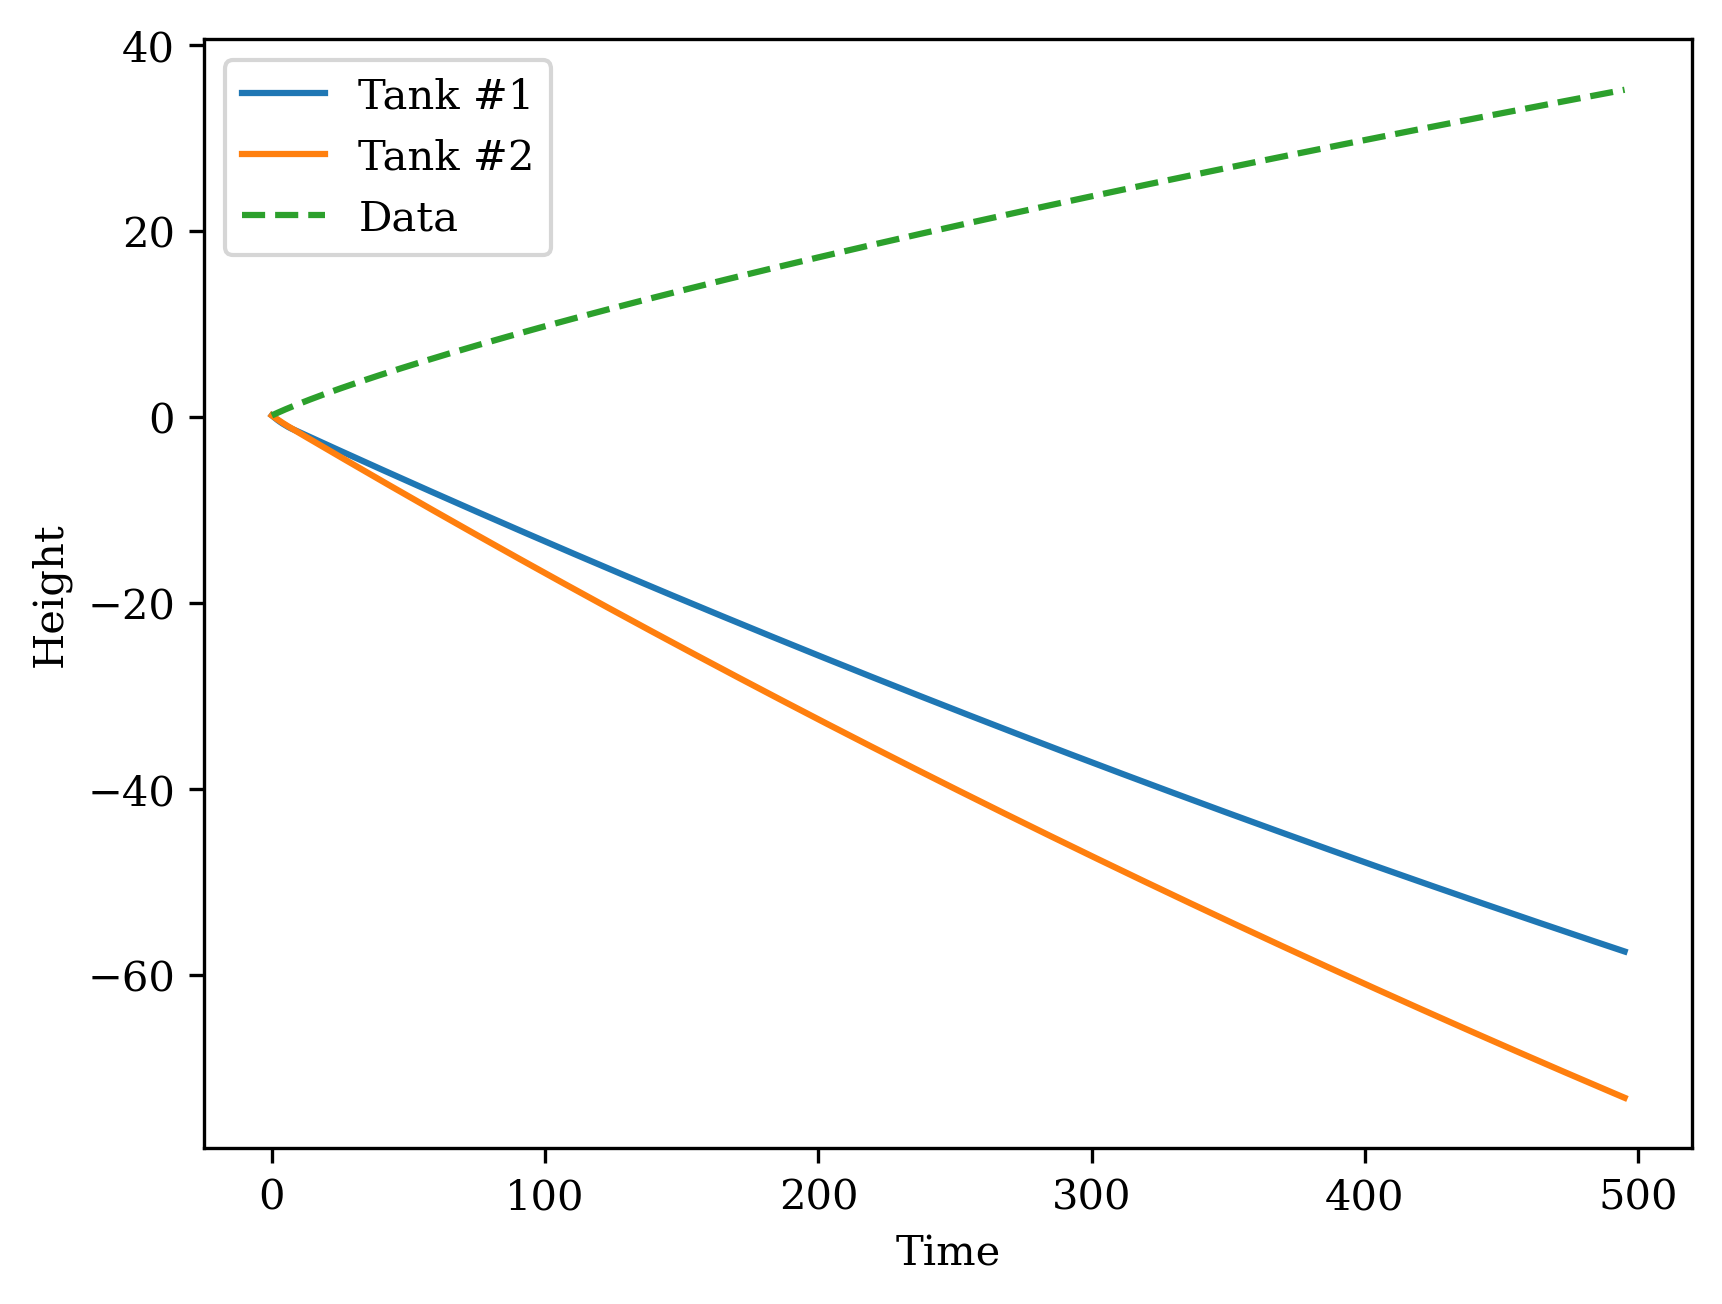

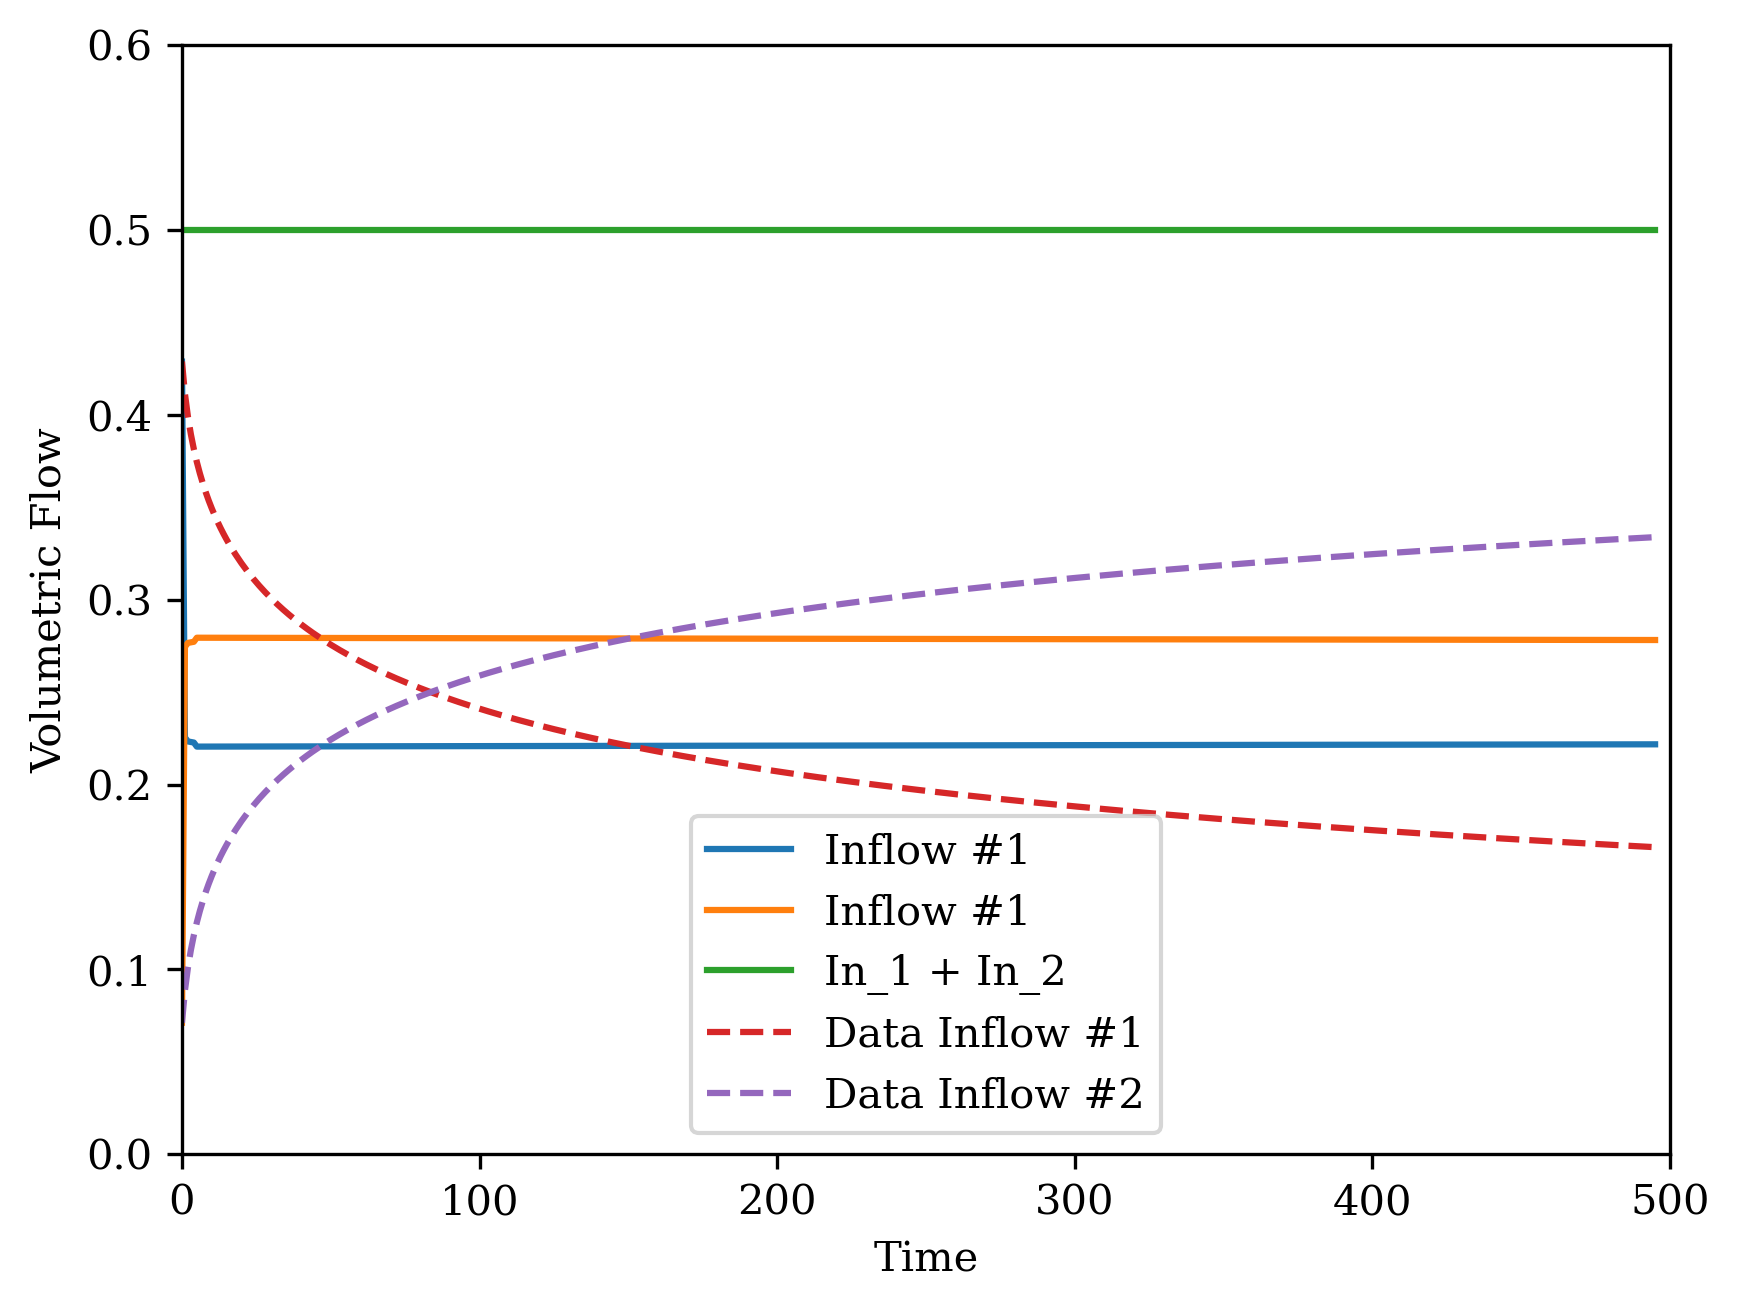

In [16]:
process_and_plot(fx_int)

It's still not looking the best, but at least the two flows combine to equal the correct inlet volumetric flow. For this problem, since we know that the dynamics obey a certain form, a gray-box (or parameter tuning) approach may be best. Let's try that next.

First, we need to instantiate a couple of Neural Networks: one to to approximate the missing tank area-height profile and another to act as a surrogate for an algebra solver:

In [17]:
# Tank area - height profiles: These should map height to area. R^1 -> R^1.
tank_profile = blocks.MLP(insize=1, outsize=1, hsizes=[3],
                            linear_map=slim.maps['linear'],
                            nonlin=nn.Sigmoid)

# Surrogate for algebra solver: This should map 'algebraic state indices' to len(state names). 
algebra_solver = blocks.MLP(insize=4, outsize=1, hsizes=[3],
                            linear_map=slim.maps['linear'],
                            nonlin=nn.Sigmoid)

Next, we need a few objects to describe the layout of the system. Becase we're now doing a gray-box model, we need to create objects of sufficient granularity/detail to evolve the height and mass flow state variables. We'll construct two `MIMOTank` objects, a pump object, a manifold object, and a set of 'pipes' that connect these objects together. Beginning with the tanks and pump, we expect these to evolve according to some pre-defined physics. For example, we know that the tanks have some area-height profile, and therefore the height scales with flow rate. This physics is built into the `MIMOTank` class. Likewise, the we need an object to anchor the exogenous input of the pump. We handle this with a `SourceSink` object - this class does not evolve states, but serves to correctly account for the integration of the exogenous input into this networked system. Note that these objects take as arguments *in_keys* and *state_keys* as arguments. Each object modifies its *state_keys* based on a forward pass that takes as input *in_keys*.

In [18]:
# Individual components:
tank_1 = physics.MIMOTank(state_keys=["h_1"], in_keys=["h_1"], profile= lambda x: 3.0) # assume known area-height profile
tank_2 = physics.MIMOTank(state_keys=["h_2"], in_keys=["h_2"], profile=tank_profile)
pump = physics.SourceSink(state_keys=["m"], in_keys=["m"])

The manifold acts to split the flow of water from the pump into the two streams. This is an algebraic relationship - we need to handle this accordingly in the gray-box model. The `SIMOConservationNode` class splits a single input into multiple outputs according to the surrogate algebra solver (a neural network in this case):

In [19]:
# Define algebraic agent:
manifold = physics.SIMOConservationNode(in_keys = ["m","h_1","h_2","m_1","m_2"], state_keys=["m_1","m_2"], solver=algebra_solver)

As with other networked systems, we combine these agents into a list for later:

In [20]:
# Accumulate agents in list:
# index:   0       1        2       3 
agents = [pump, tank_1, tank_2, manifold]

The different agents are connected via `Pipe` couplings. Just like real pipes in a fluid system, these transport flows from one node in the network to another. Here, we have three fluid streams that need to be defined: (i) from the pump to the manifold, (ii) from the manifld to tank #1, and (iii) from the manifold to tank #2:

In [21]:
couplings = []
# Couple w/ pipes:
couplings.append(physics.Pipe(in_keys = ["m"], pins = [[0,3]])) # Pump -> Manifold
couplings.append(physics.Pipe(in_keys = ["m_1"], pins = [[3,1]])) # Manifold -> tank_1
couplings.append(physics.Pipe(in_keys = ["m_2"], pins = [[3,2]])) # Manifold -> tank_2

The agents and couplings are aggregated via the `GeneralNetworkedODE` and `GeneralNetworkedAE` classes:

In [22]:

model_ode = ode.GeneralNetworkedODE(
    states=states,
    agents=agents,
    couplings=couplings,
    insize=nx+nu,
    outsize=nx,
)

model_algebra = ode.GeneralNetworkedAE(
    states=states,
    agents=agents,
    insize=nx+nu,
    outsize=nx,
)

Finally, we can put all of the pieces together to form a complete model:

In [23]:
# Construct the new timestepper:
fx_dae = integrators.EulerDAE(model_ode,algebra=model_algebra,h=1.0)
dynamics_model = System([Node(fx_dae,['xn','U'],['xn'])])

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)
optimizer = torch.optim.Adam(problem.parameters(), lr=0.005)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=10000,
    patience=50,
    warmup=50,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=None,
)

In [24]:
best_model = trainer.train()

epoch: 0  train_loss: 310.34918212890625
epoch: 1  train_loss: 278.7632141113281
epoch: 2  train_loss: 251.16856384277344
epoch: 3  train_loss: 226.94677734375
epoch: 4  train_loss: 205.60923767089844
epoch: 5  train_loss: 186.73086547851562
epoch: 6  train_loss: 169.94625854492188
epoch: 7  train_loss: 154.9827117919922
epoch: 8  train_loss: 141.59767150878906
epoch: 9  train_loss: 129.58682250976562
epoch: 10  train_loss: 118.76676177978516
epoch: 11  train_loss: 108.98588562011719
epoch: 12  train_loss: 100.13383483886719
epoch: 13  train_loss: 92.10533142089844
epoch: 14  train_loss: 84.80810546875
epoch: 15  train_loss: 78.16185760498047
epoch: 16  train_loss: 72.09599304199219
epoch: 17  train_loss: 66.53936767578125
epoch: 18  train_loss: 61.44959259033203
epoch: 19  train_loss: 56.77900695800781
epoch: 20  train_loss: 52.48501968383789
epoch: 21  train_loss: 48.52889633178711
epoch: 22  train_loss: 44.870033264160156
epoch: 23  train_loss: 41.475059509277344
epoch: 24  train_lo

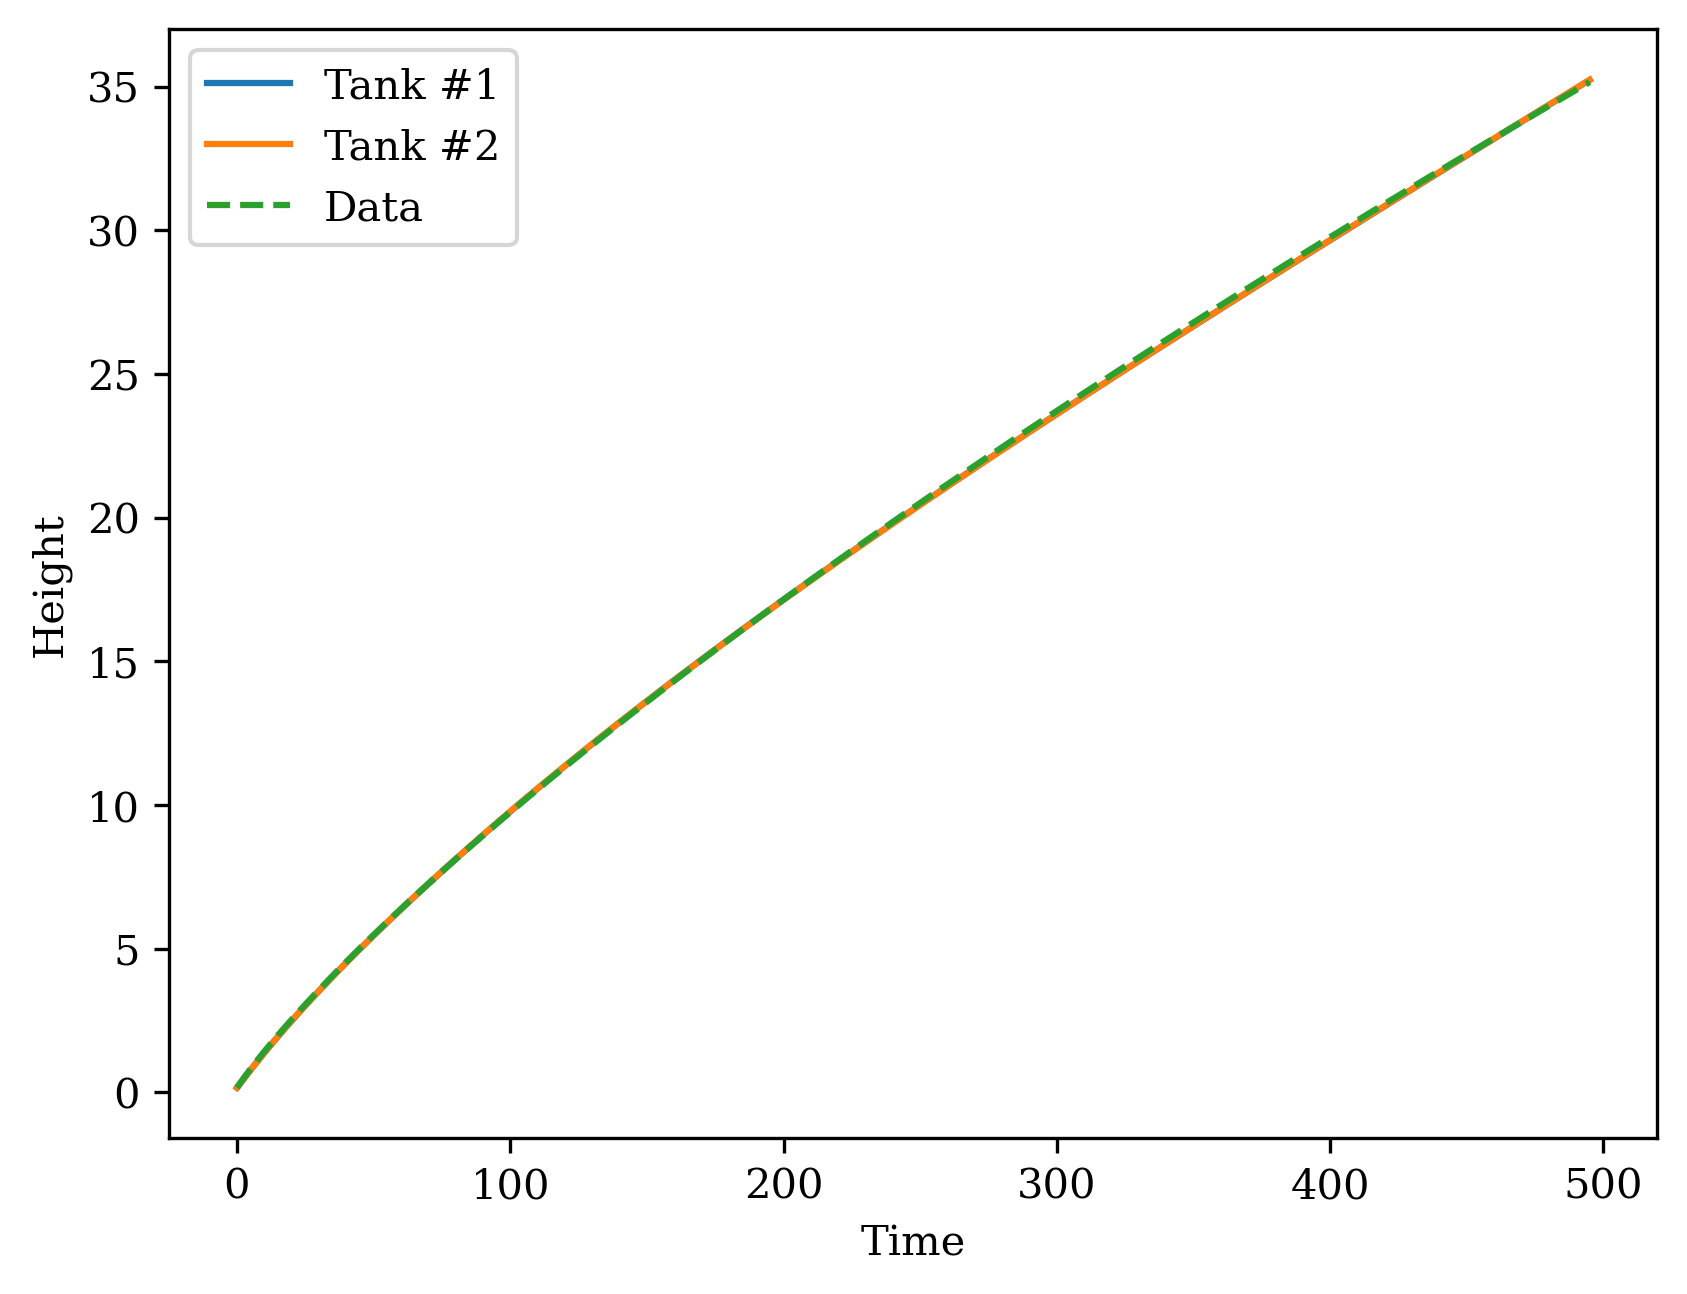

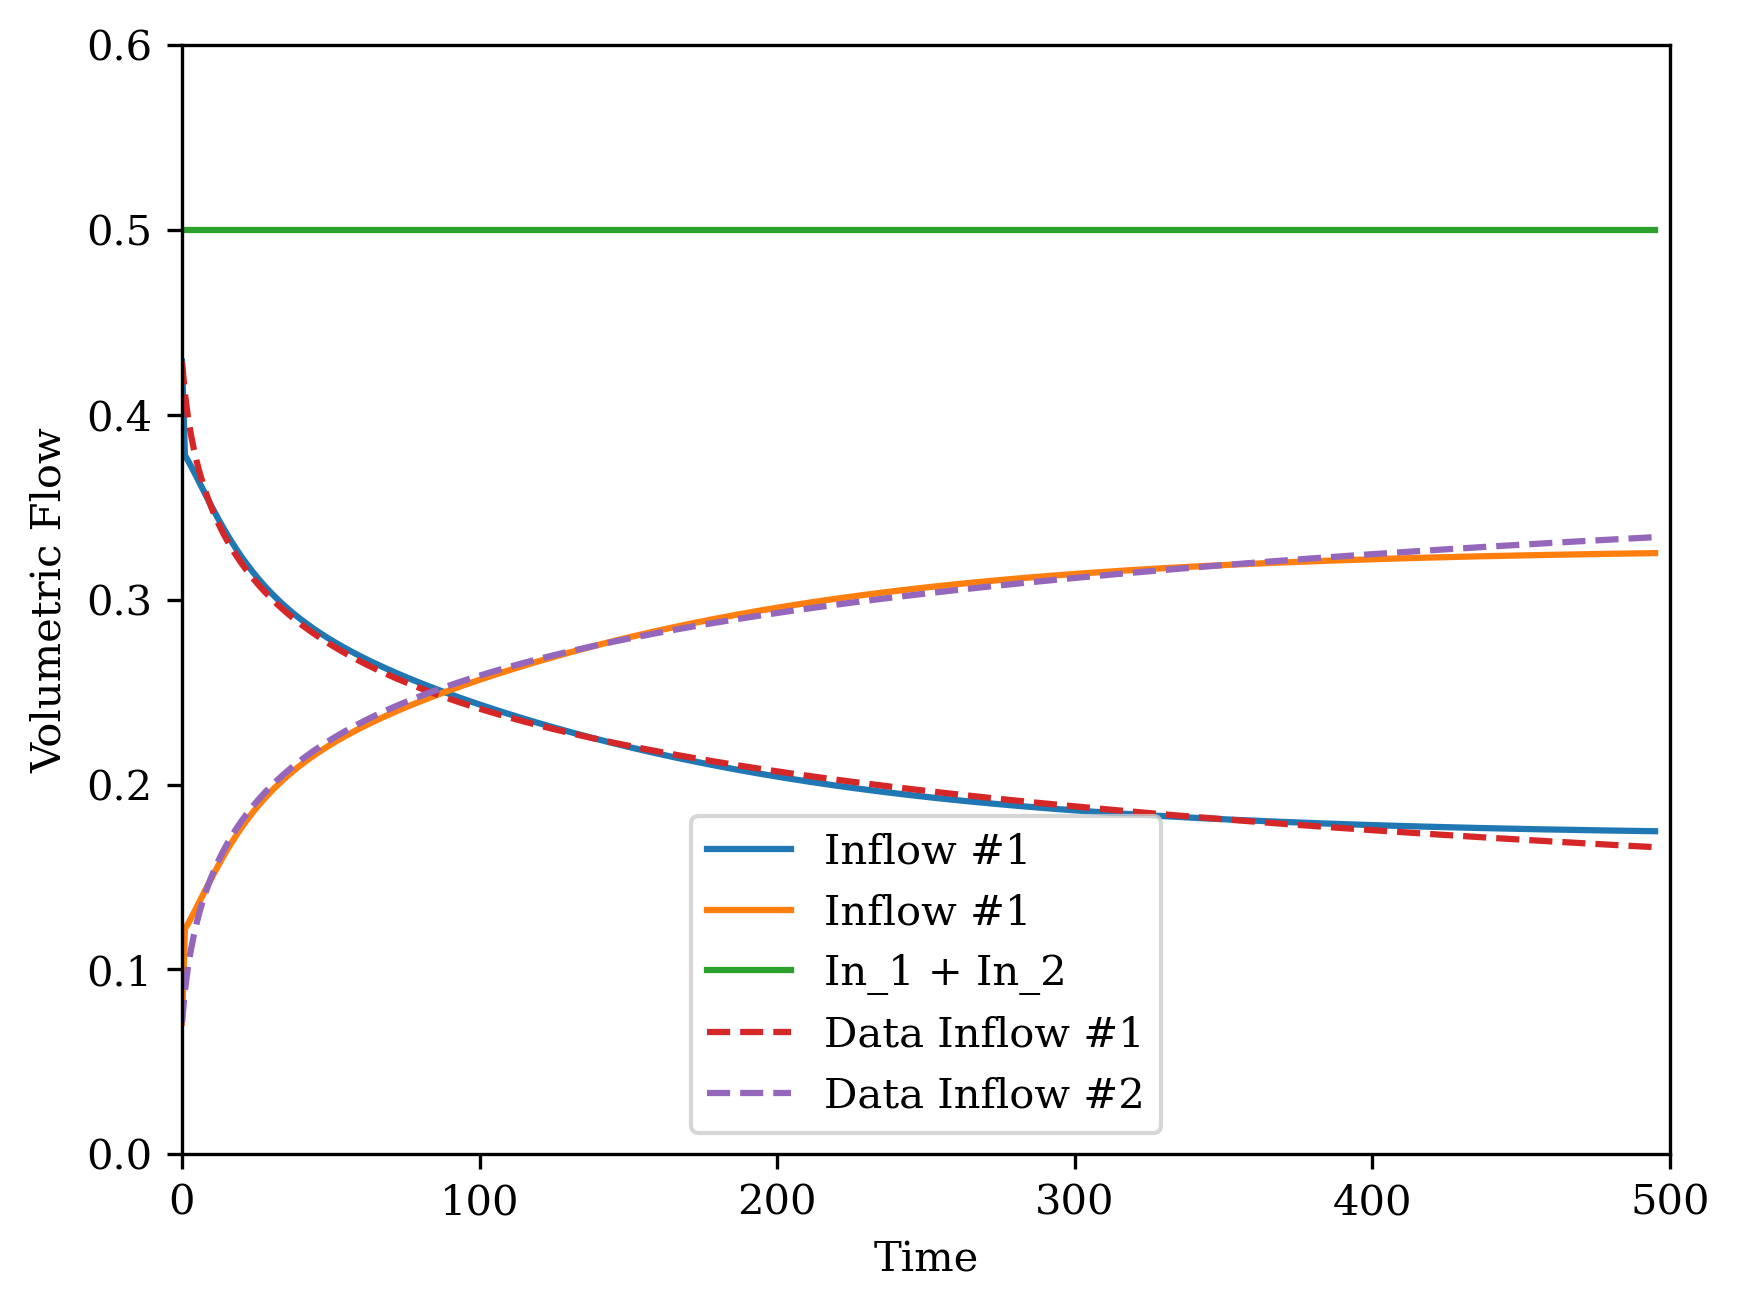

In [25]:
process_and_plot(fx_dae)